In [1]:
import pandas as pd
import numpy as np
import os
from IPython.display import Audio
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D, Flatten, BatchNormalization, Activation, Masking, Input, InputLayer, Reshape
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.python.keras import optimizers
from tensorflow.keras.optimizers import SGD

In [2]:
file_name_dataset = "RAVDESS"
dataset_ravdess_dir = "../Dataset/RAVDESS/"
ravdess_dir_list = os.listdir(dataset_ravdess_dir)

In [3]:
emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}

In [4]:
emotion_list = []
path_list = []

for dir in ravdess_dir_list:
    for audio_file in os.listdir(dataset_ravdess_dir + dir):
        emotion_segment = audio_file.split("-")[2]

        if emotion_segment in emotion_dict:
            emotion_list.append(emotion_dict[emotion_segment])
        else:
            emotion_list.append("unknown")

        audio_file_path = os.path.join(dataset_ravdess_dir, dir, audio_file)
        path_list.append(audio_file_path)

ravdess_df = pd.DataFrame({'Emotion': emotion_list, 'Path': path_list})
ravdess_df.to_csv("ravdess_df.csv", index = False)
ravdess_df.head()

,Emotion,Path
0,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-01-...
1,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-01-02-...
2,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-01-...
3,neutral,../Dataset/RAVDESS/Actor_01\03-01-01-01-02-02-...
4,calm,../Dataset/RAVDESS/Actor_01\03-01-02-01-01-01-...


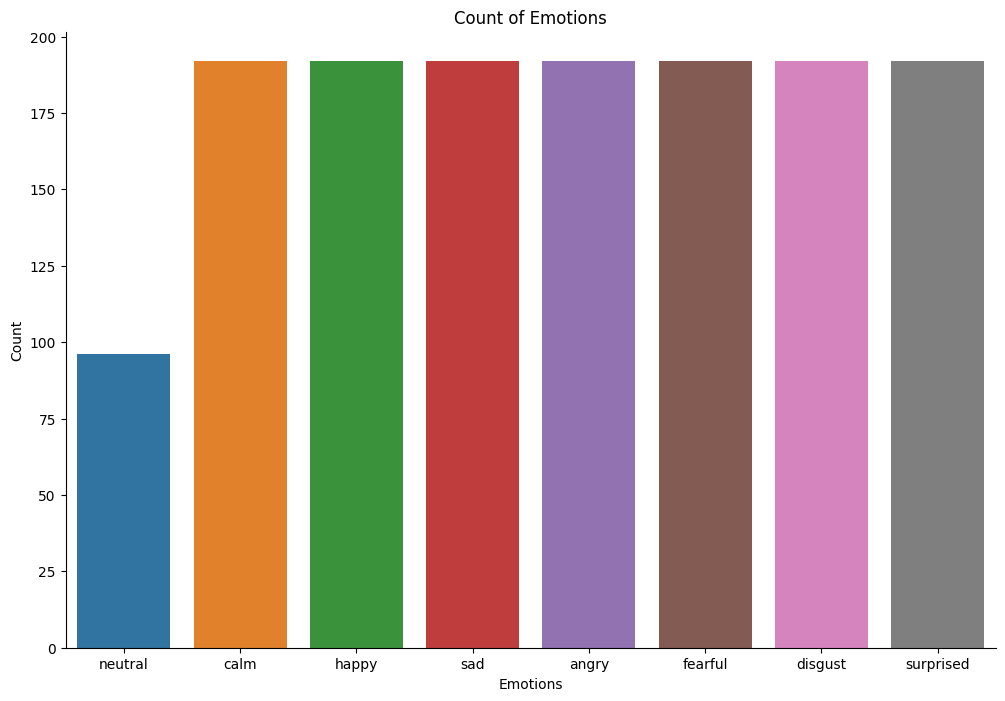

In [5]:
plt.figure(figsize=(12, 8))
plt.title('Count of Emotions')
sns.countplot(x = ravdess_df.Emotion)
plt.ylabel('Count')
plt.xlabel('Emotions')
sns.despine(top = True, right = True, left = False, bottom = False)
plt.show()

In [6]:
def noise(data):
  noise_amp = 0.04 * np.random.uniform() * np.amax(data)
  data = data + noise_amp * np.random.normal(size = data.shape[0])
  return data

def time_stretch(data, rate = 0.8):
  return librosa.effects.time_stretch(data, rate = rate)

def shift(data, steps_range = (-5, 5)):
  shift_range = int(np.random.uniform(steps_range[0], steps_range[1]) * 1000)
  return np.roll(data, shift_range)

def pitch_shift(data, sampling_rate, n_steps = 0.7):
  return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = n_steps)

def random_time_stretch(data, stretch_factor_range = (0.8, 1.25)):
  random_stretch_factor = np.random.uniform(stretch_factor_range[0], stretch_factor_range[1])

  augmented_data = time_stretch(data, random_stretch_factor)

  if len(augmented_data) > len(data):
    augmented_data = augmented_data[:len(data)]
  else:
    padded_augmented_data = np.zeros_like(data)
    padded_augmented_data[:len(augmented_data)] = augmented_data
    augmented_data = padded_augmented_data

  return augmented_data

def random_pitch_shift(data, sampling_rate, steps_range=(-4, 4)):
  n_steps = np.random.randint(steps_range[0], steps_range[1] + 1)  
  return pitch_shift(data, sampling_rate, n_steps)

In [7]:
def extract_mel(data, sr, n_mels=128, fmax=8000):
    mel_spec = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=n_mels, fmax=fmax)
    return mel_spec;

def extract_log_mel_spec(data, sr, n_mels=128, fmax=8000):
    log_mel_spec = librosa.power_to_db(extract_mel(data, sr, n_mels, fmax))
    return log_mel_spec;

def extract_mfcc(data, sr, n_mfcc=13):
    mfcc = librosa.feature.mfcc(y = data, sr = sr, n_mfcc=n_mfcc)
    return mfcc;

def extract_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta_mfcc = librosa.feature.delta(mfcc)
    return delta_mfcc;

def extract_delta_delta_mfcc(data, sr, n_mfcc=13):
    mfcc = extract_mfcc(data, sr, n_mfcc)
    delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    return delta2_mfcc;

def extract_zcr(data):
    zcr = librosa.feature.zero_crossing_rate(y=data)
    return zcr

def extract_rms(data):
    rms = librosa.feature.rms(y=data)
    return rms

In [8]:
# feature_extraction_techniques = ["MFCC", "Delta MFCC", "Delta Delta MFCC"]
# feature_extraction_techniques = ["MFCC Mean 40", "Delta MFCC Mean 40", "Delta Delta MFCC Mean 40"]
feature_extraction_techniques = ["MFCC Mean 40"]

file_name_feat_extract = " & ".join(feature_extraction_techniques)

def extract_features(data, sr, n_mfcc=40):
    # MEAN
    features = np.array([])
    mfcc = extract_mfcc(data, sr, n_mfcc).T
    delta_mfcc = extract_delta_mfcc(data, sr, n_mfcc).T
    delta_delta_mfcc = extract_delta_delta_mfcc(data, sr, n_mfcc).T
    mfcc_mean = np.mean(mfcc, axis=0)
    delta_mfcc_mean = np.mean(delta_mfcc, axis=0)
    delta_delta_mfcc_mean = np.mean(delta_delta_mfcc, axis=0)
    # mfcc_min = np.min(mfcc, axis=0)
    # mfcc_max = np.max(mfcc, axis=0)
    # mfcc_std = np.std(mfcc, axis=0)
    # zcr = np.mean(extract_zcr(data))
    # rms = np.mean(extract_rms(data))
    features = np.hstack((features, mfcc_mean))

    # ENTIRE FEATURE
    # mfcc = extract_mfcc(data, sr).T
    # delta_mfcc = extract_delta_mfcc(data, sr).T
    # delta_delta_mfcc = extract_delta_delta_mfcc(data, sr).T
    # features = np.concatenate((mfcc, delta_mfcc, delta_delta_mfcc), axis=1)
    
    return features

In [9]:
# data_augmentation_techniques = ["Noise", "Random Time Stretch", "Random Pitch Shift"]
# data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "Stretched 0.7", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]
data_augmentation_techniques = ["Noise 0.04", "Low Speed 0.75", "High Speed 1.25", "Pitch Shift 0.7", "Shift (-5, 5)"]

file_name_data_aug = " & ".join(data_augmentation_techniques)

def get_features(path):
    data, sampling_rate = librosa.load(path, duration=3, offset=0.5)

    noisy_data = noise(data)

    lowspeed_data = time_stretch(data, rate=0.75) #Ignore this
    stretched_data = time_stretch(data, rate=0.7) #Ignore this
    highspeed_data = time_stretch(data, rate=1.25) #Ignore this
    pitch_shift_data = pitch_shift(data, sampling_rate, n_steps=0.7) #Ignore this
    shift_data = shift(data, (-5, 5)) #Ignore this

    random_time_stretch_data = random_time_stretch(data, (0.8, 1.25))
    random_pitch_shift_data = random_pitch_shift(data, sampling_rate, (-4, 4))

    features = extract_features(data, sampling_rate)
    noisy_features = extract_features(noisy_data, sampling_rate)
    
    lowspeed_features = extract_features(lowspeed_data, sampling_rate) #Ignore this
    stretched_features = extract_features(stretched_data, sampling_rate) #Ignore this
    highspeed_features = extract_features(highspeed_data, sampling_rate) #Ignore this
    pitch_shift_features = extract_features(pitch_shift_data, sampling_rate) #Ignore this
    shift_features = extract_features(shift_data, sampling_rate) #Ignore this

    random_time_stretch_features = extract_features(random_time_stretch_data, sampling_rate)
    random_pitch_shift_features = extract_features(random_pitch_shift_data, sampling_rate)

    # result = np.vstack((features, noisy_features, random_time_stretch_features, random_pitch_shift_features))
    result = np.vstack((features, noisy_features, lowspeed_features, highspeed_features, pitch_shift_features, shift_features))

    return result

In [10]:
filename = file_name_dataset + " # " + file_name_feat_extract + " # " + file_name_data_aug

def create_feature_dataframe(dataframe):
    feature_list = []
    emotion_list = []

    for path, emotion in tqdm(zip(dataframe.Path, dataframe.Emotion), total=len(dataframe)):
        features = get_features(path)
        for elements in features:
            feature_list.append(elements)
            emotion_list.append(emotion)

    df = pd.DataFrame({'Emotion': emotion_list})
    df = pd.concat([df, pd.DataFrame(feature_list)], axis=1)
    df.to_csv(filename + '.csv', index=False)

    return df

In [11]:
file_exists = os.path.exists(filename + '.csv')

if file_exists:
    df = pd.read_csv(filename + '.csv')
else:
    df = create_feature_dataframe(ravdess_df)

df.head()

,Emotion,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,neutral,-670.195435,65.063850,0.888954,14.715979,9.182164,0.660575,-3.846836,-3.583946,-12.959006,...,-2.351098,-2.504727,-3.151507,-2.190899,-3.801760,-1.813088,-1.261222,-2.144954,-4.152173,-1.779615
1,neutral,-414.761523,21.981434,8.014797,7.191777,3.978840,-0.291529,-2.458150,-5.639966,-7.070693,...,-1.300621,-1.436600,-1.493561,-1.958838,-2.061660,-0.920873,-0.248039,-1.327291,-1.568317,-1.893178
2,neutral,-691.445679,62.221443,-0.300504,14.352509,8.497726,0.746647,-4.348557,-4.798969,-14.069670,...,-2.381158,-2.261819,-2.873888,-1.883212,-4.045451,-1.785669,-1.113154,-2.164787,-4.364875,-1.768830
3,neutral,-712.516907,66.194984,1.424330,16.236750,9.380598,1.506902,-4.124938,-3.517112,-13.283334,...,-1.922169,-2.280859,-3.436191,-1.829611,-4.056078,-1.664588,-0.654646,-1.566690,-4.341530,-1.645019
4,neutral,-697.627258,62.472347,-1.029173,15.987646,7.447986,-0.467146,-5.220094,-5.383532,-13.847498,...,-4.750515,-3.052244,-4.137149,-2.542254,-3.379075,-0.843549,-2.677613,-4.869622,-3.312335,-3.609416


In [12]:
X = df.iloc[:, 1:].values
Y = df['Emotion'].values

In [13]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [14]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=True)
x_validation, x_test, y_validation, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=42, shuffle=True)

In [15]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)

x_train.shape, y_train.shape, x_validation.shape, y_validation.shape, x_test.shape, y_test.shape

((6912, 40), (6912, 8), (864, 40), (864, 8), (864, 40), (864, 8))

In [16]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)
X_validation = x_validation.reshape(x_validation.shape[0] , x_validation.shape[1] , 1)
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape, y_test.shape

((6912, 40, 1), (6912, 8), (864, 40, 1), (864, 8), (864, 40, 1), (864, 8))

In [17]:
def evaluate_model(model):
    loss, accuracy = model.evaluate(X_test, y_test, verbose=1)

    print(f'Test Loss: {loss}')
    print(f'Test Accuracy: {accuracy}')

In [18]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

In [19]:
def simplify_label(label):
    if 'angry' in label:
        return 'angry'
    elif 'disgust' in label:
        return 'disgust'
    elif 'fear' in label:
        return 'fear'
    elif 'happy' in label:
        return 'happy'
    elif 'sad' in label:
        return 'sad'
    elif 'surprise' in label:
        return 'surprise'
    elif 'neutral' in label:
        return 'neutral'
    else:
        return label

In [20]:
def create_model_summary(model_type):
    test_prediction = model_type.predict(X_test)

    prediction_actual_df = pd.DataFrame({
    'Predicted': encoder.inverse_transform(test_prediction).flatten(),
    'Actual': encoder.inverse_transform(y_test).flatten()
    })

    prediction_actual_df.head()

    modified_df = prediction_actual_df.copy()
    modified_df['Actual'] = modified_df['Actual'].apply(simplify_label)
    modified_df['Predicted'] = modified_df['Predicted'].apply(simplify_label)

    res_mat = confusion_matrix(modified_df['Actual'], modified_df['Predicted'])
    plt.figure(figsize=(10, 7))
    sns.heatmap(res_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=modified_df['Predicted'].unique(), 
                yticklabels=modified_df['Actual'].unique())
    plt.xlabel('Predicted Labels')
    plt.ylabel('Actual Labels')
    plt.title('Confusion Matrix')
    plt.show()

    print(classification_report(modified_df['Actual'], modified_df['Predicted']))

    accuracy = accuracy_score(modified_df['Actual'], modified_df['Predicted'])
    print(f"Accuracy: {round(accuracy * 100, 2)}%")

In [21]:
resnet50_weights_path = '../ResNet/resnet50v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet101_weights_path = '../ResNet/resnet101v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
resnet152_weights_path = '../ResNet/resnet152v2_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [22]:
def create_resnet_model(model_type, epochs, filename):
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    input_layer = Input(shape=input_shape)

    model_map = {
        'EfficientNetB0': EfficientNetB0,
        'EfficientNetB1': EfficientNetB1,
        'EfficientNetB2': EfficientNetB2,
        'EfficientNetB3': EfficientNetB3,
        'EfficientNetB4': EfficientNetB4,
        'EfficientNetB5': EfficientNetB5,
        'EfficientNetB6': EfficientNetB6,
        'EfficientNetB7': EfficientNetB7,
        'EfficientNetV2B0': EfficientNetV2B0,
        'EfficientNetV2B1': EfficientNetV2B1,
        'EfficientNetV2B2': EfficientNetV2B2,
        'EfficientNetV2B3': EfficientNetV2B3,
        'EfficientNetV2S': EfficientNetV2S,
        'EfficientNetV2M': EfficientNetV2M,
        'EfficientNetV2L': EfficientNetV2L
    }

    if model_type not in model_map:
        raise ValueError("Invalid model_type provided. Please choose from EfficientNetB0, B1, B2, B3, B4, B5, B6, B7, V2B0, V2B1, V2B2, V2B3, V2S, V2M, V2L.")

    base_model = model_map[model_type](weights=None, include_top=False, input_tensor=input_layer, pooling='avg')

    x = base_model.output
    output_layer = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output_layer)
    model.summary()
    
    sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=3, min_lr=0.00001)
    checkpoint = ModelCheckpoint(filepath=filename + '_best.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    early_stop = EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        validation_data=(X_validation, y_validation),
        callbacks=[reduce_lr, early_stop, checkpoint]
    )
    
    return model, history

Training model: EfficientNetB0
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1, 1)]   0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 40, 1, 1)     0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 40, 1, 1)     3           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 41, 3, 1)     0           ['normalization[0][0]']          
                                                               

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
216/216 [==============================] - ETA: 0s - loss: 2.1291 - accuracy: 0.2381
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to RAVDESS 100EfficientNetB0_best.h5
216/216 [==============================] - 164s 529ms/step - loss: 2.1291 - accuracy: 0.2381 - val_loss: 2.0881 - val_accuracy: 0.1354 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 1.8112 - accuracy: 0.3336
Epoch 2: val_accuracy improved from 0.13542 to 0.15741, saving model to RAVDESS 100EfficientNetB0_best.h5
216/216 [==============================] - 107s 496ms/step - loss: 1.8112 - accuracy: 0.3336 - val_loss: 2.1390 - val_accuracy: 0.1574 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 1.5390 - accuracy: 0.4317
Epoch 3: val_accuracy improved from 0.15741 to 0.26620, saving model to RAVDESS 100EfficientNetB0_best.h5
216/216 [==============================] - 101s 470ms/step - loss: 1.5390 - accuracy: 0.4317 - val

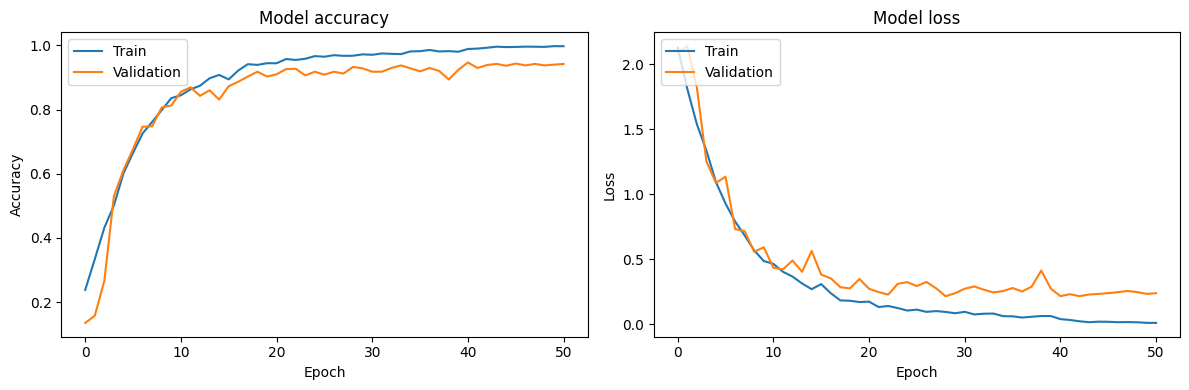

27/27 [==============================] - 2s 26ms/step


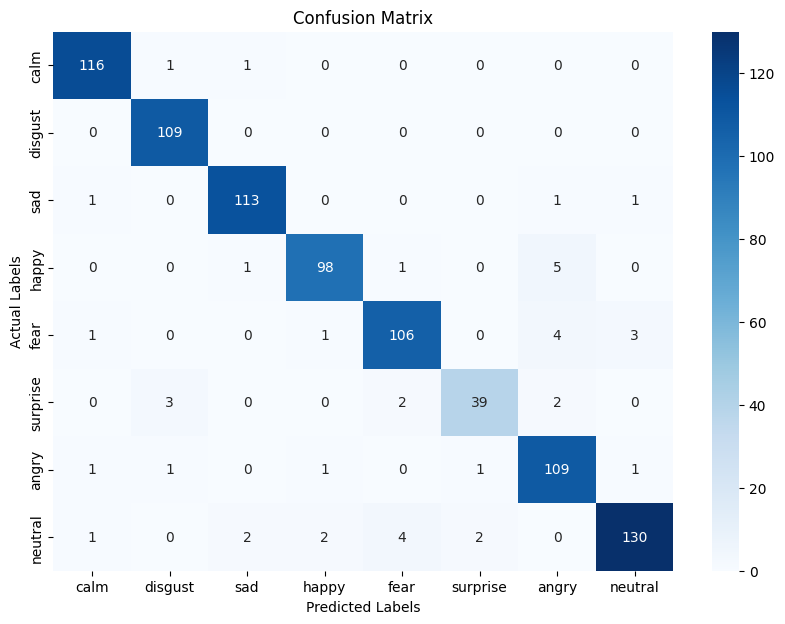

              precision    recall  f1-score   support

       angry       0.97      0.98      0.97       118
        calm       0.96      1.00      0.98       109
     disgust       0.97      0.97      0.97       116
        fear       0.96      0.93      0.95       105
       happy       0.94      0.92      0.93       115
     neutral       0.93      0.85      0.89        46
         sad       0.90      0.96      0.93       114
    surprise       0.96      0.92      0.94       141

    accuracy                           0.95       864
   macro avg       0.95      0.94      0.94       864
weighted avg       0.95      0.95      0.95       864

Accuracy: 94.91%
Training model: EfficientNetB1
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.1783 - accuracy: 0.2248
Epoch 1: val_accuracy improved from -inf to 0.13773, saving model to RAVDESS 100EfficientNetB1_best.h5
216/216 [==============================] - 52s 196ms/step - loss: 2.1783 - accuracy: 0.2248 - val_loss: 2.0665 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 1.8052 - accuracy: 0.3288
Epoch 2: val_accuracy did not improve from 0.13773
216/216 [==============================] - 39s 180ms/step - loss: 1.8052 - accuracy: 0.3288 - val_loss: 2.0792 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 1.6370 - accuracy: 0.3882
Epoch 3: val_accuracy improved from 0.13773 to 0.20370, saving model to RAVDESS 100EfficientNetB1_best.h5
216/216 [==============================] - 40s 187ms/step - loss: 1.6370 - accuracy: 0.3882 - val_loss: 1.9624 - val_accuracy: 0.2037 - lr: 0.0100
Epoch 4/100
216/216 

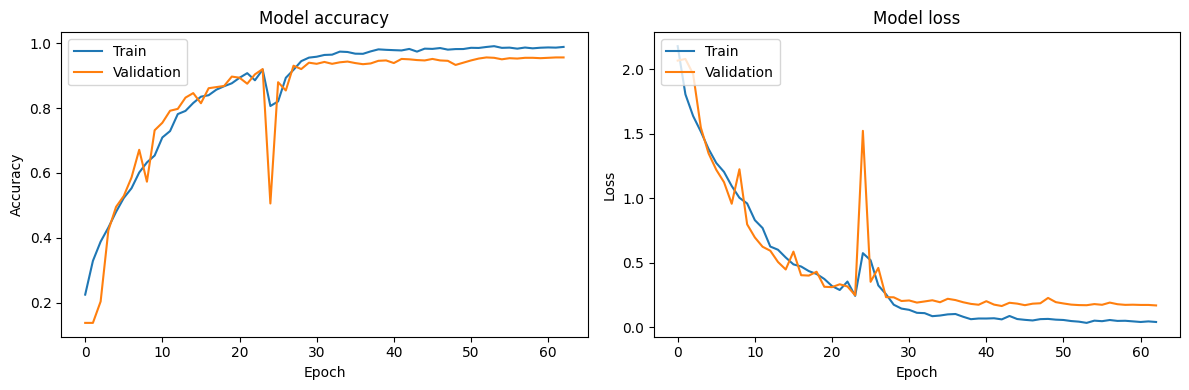

27/27 [==============================] - 3s 37ms/step


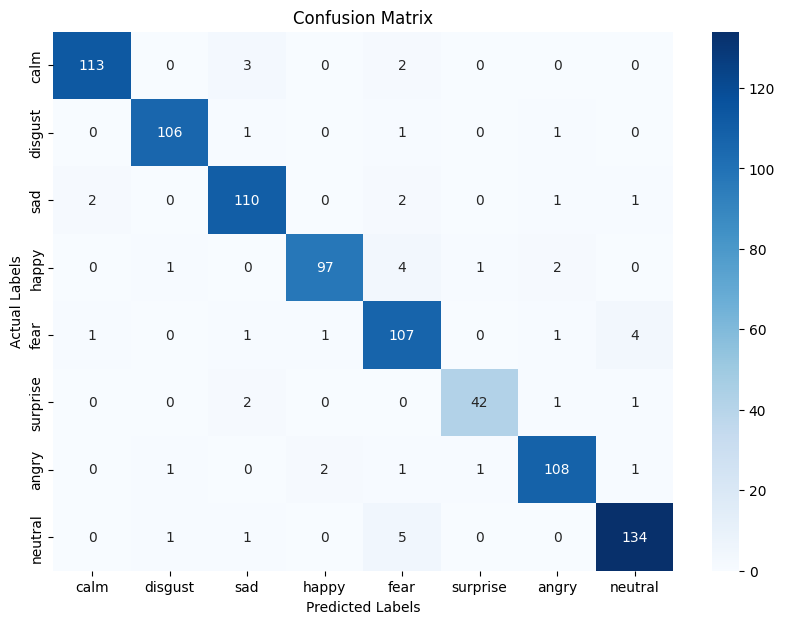

              precision    recall  f1-score   support

       angry       0.97      0.96      0.97       118
        calm       0.97      0.97      0.97       109
     disgust       0.93      0.95      0.94       116
        fear       0.97      0.92      0.95       105
       happy       0.88      0.93      0.90       115
     neutral       0.95      0.91      0.93        46
         sad       0.95      0.95      0.95       114
    surprise       0.95      0.95      0.95       141

    accuracy                           0.95       864
   macro avg       0.95      0.94      0.94       864
weighted avg       0.95      0.95      0.95       864

Accuracy: 94.56%
Training model: EfficientNetB2
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.2532 - accuracy: 0.1837
Epoch 1: val_accuracy improved from -inf to 0.13773, saving model to RAVDESS 100EfficientNetB2_best.h5
216/216 [==============================] - 55s 202ms/step - loss: 2.2532 - accuracy: 0.1837 - val_loss: 2.0695 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 1.9089 - accuracy: 0.2915
Epoch 2: val_accuracy did not improve from 0.13773
216/216 [==============================] - 40s 185ms/step - loss: 1.9089 - accuracy: 0.2915 - val_loss: 2.0733 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 1.7197 - accuracy: 0.3556
Epoch 3: val_accuracy improved from 0.13773 to 0.19097, saving model to RAVDESS 100EfficientNetB2_best.h5
216/216 [==============================] - 42s 195ms/step - loss: 1.7197 - accuracy: 0.3556 - val_loss: 1.9631 - val_accuracy: 0.1910 - lr: 0.0100
Epoch 4/100
216/216 

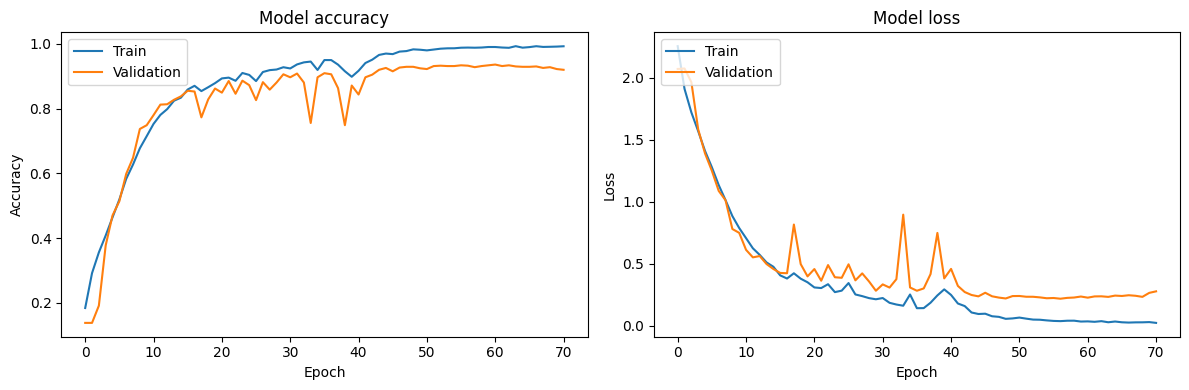

27/27 [==============================] - 2s 26ms/step


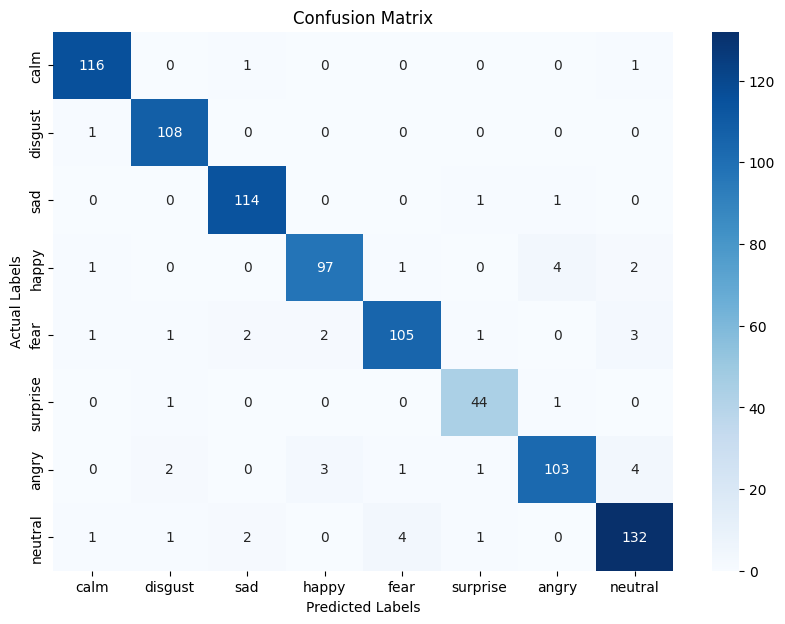

              precision    recall  f1-score   support

       angry       0.97      0.98      0.97       118
        calm       0.96      0.99      0.97       109
     disgust       0.96      0.98      0.97       116
        fear       0.95      0.92      0.94       105
       happy       0.95      0.91      0.93       115
     neutral       0.92      0.96      0.94        46
         sad       0.94      0.90      0.92       114
    surprise       0.93      0.94      0.93       141

    accuracy                           0.95       864
   macro avg       0.95      0.95      0.95       864
weighted avg       0.95      0.95      0.95       864

Accuracy: 94.79%
Training model: EfficientNetB3
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.3200 - accuracy: 0.1531
Epoch 1: val_accuracy improved from -inf to 0.13542, saving model to RAVDESS 100EfficientNetB3_best.h5
216/216 [==============================] - 39s 136ms/step - loss: 2.3200 - accuracy: 0.1531 - val_loss: 2.0640 - val_accuracy: 0.1354 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 2.0301 - accuracy: 0.2306
Epoch 2: val_accuracy did not improve from 0.13542
216/216 [==============================] - 27s 123ms/step - loss: 2.0301 - accuracy: 0.2306 - val_loss: 2.0776 - val_accuracy: 0.1354 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 1.8717 - accuracy: 0.2867
Epoch 3: val_accuracy improved from 0.13542 to 0.21528, saving model to RAVDESS 100EfficientNetB3_best.h5
216/216 [==============================] - 27s 126ms/step - loss: 1.8717 - accuracy: 0.2867 - val_loss: 1.9274 - val_accuracy: 0.2153 - lr: 0.0100
Epoch 4/100
216/216 

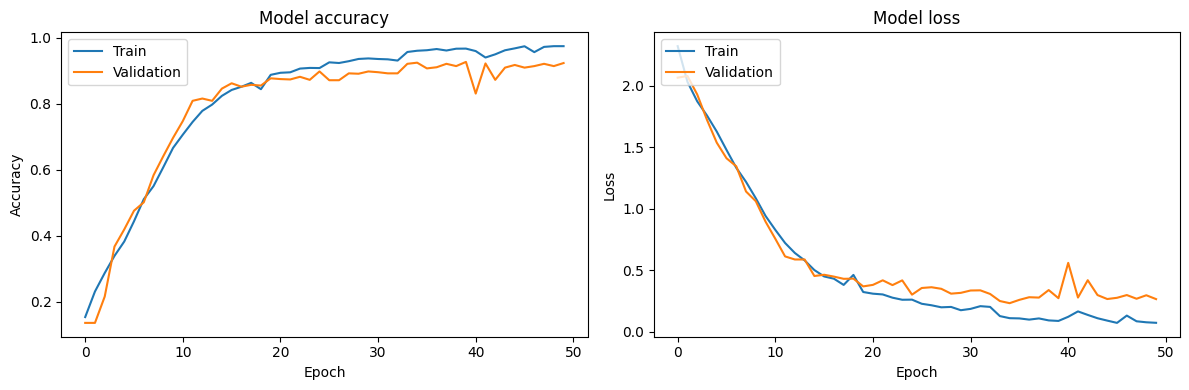

27/27 [==============================] - 2s 31ms/step


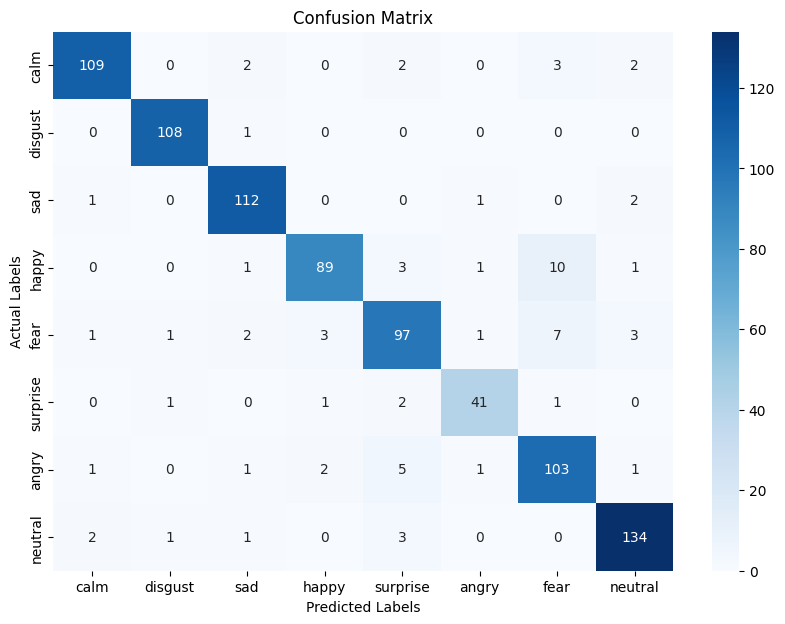

              precision    recall  f1-score   support

       angry       0.96      0.92      0.94       118
        calm       0.97      0.99      0.98       109
     disgust       0.93      0.97      0.95       116
        fear       0.94      0.85      0.89       105
       happy       0.87      0.84      0.85       115
     neutral       0.91      0.89      0.90        46
         sad       0.83      0.90      0.87       114
    surprise       0.94      0.95      0.94       141

    accuracy                           0.92       864
   macro avg       0.92      0.91      0.92       864
weighted avg       0.92      0.92      0.92       864

Accuracy: 91.78%
Training model: EfficientNetB4
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.3656 - accuracy: 0.1497
Epoch 1: val_accuracy improved from -inf to 0.13773, saving model to RAVDESS 100EfficientNetB4_best.h5
216/216 [==============================] - 49s 172ms/step - loss: 2.3656 - accuracy: 0.1497 - val_loss: 2.0703 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 2.0809 - accuracy: 0.1848
Epoch 2: val_accuracy did not improve from 0.13773
216/216 [==============================] - 34s 155ms/step - loss: 2.0809 - accuracy: 0.1848 - val_loss: 2.0829 - val_accuracy: 0.1285 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 1.9829 - accuracy: 0.2397
Epoch 3: val_accuracy improved from 0.13773 to 0.17014, saving model to RAVDESS 100EfficientNetB4_best.h5
216/216 [==============================] - 35s 160ms/step - loss: 1.9829 - accuracy: 0.2397 - val_loss: 2.0189 - val_accuracy: 0.1701 - lr: 0.0100
Epoch 4/100
216/216 

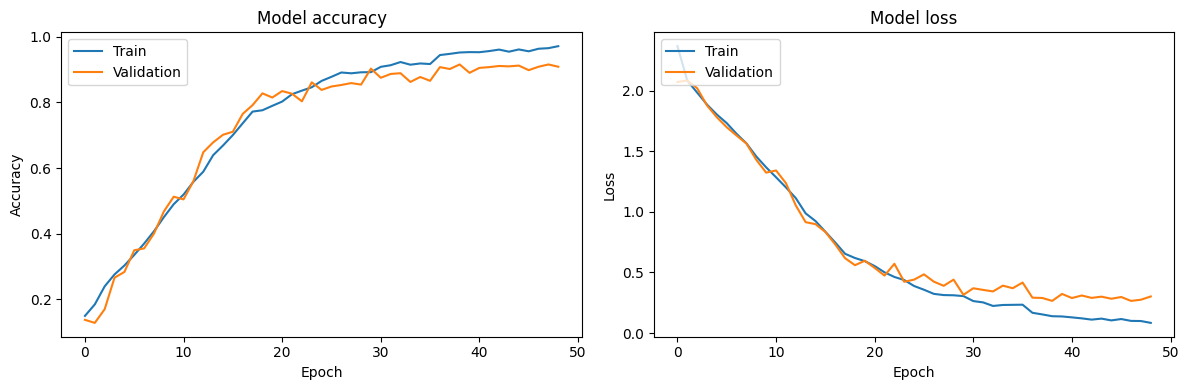

27/27 [==============================] - 3s 34ms/step


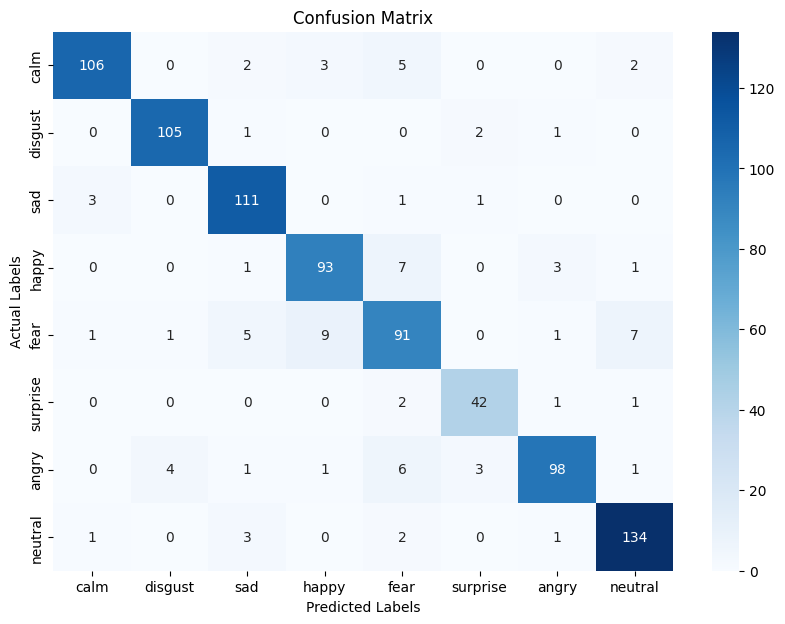

              precision    recall  f1-score   support

       angry       0.95      0.90      0.93       118
        calm       0.95      0.96      0.96       109
     disgust       0.90      0.96      0.93       116
        fear       0.88      0.89      0.88       105
       happy       0.80      0.79      0.79       115
     neutral       0.88      0.91      0.89        46
         sad       0.93      0.86      0.89       114
    surprise       0.92      0.95      0.93       141

    accuracy                           0.90       864
   macro avg       0.90      0.90      0.90       864
weighted avg       0.90      0.90      0.90       864

Accuracy: 90.28%
Training model: EfficientNetB5
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.4217 - accuracy: 0.1437
Epoch 1: val_accuracy improved from -inf to 0.13657, saving model to RAVDESS 100EfficientNetB5_best.h5
216/216 [==============================] - 63s 223ms/step - loss: 2.4217 - accuracy: 0.1437 - val_loss: 2.0709 - val_accuracy: 0.1366 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 2.0540 - accuracy: 0.2072
Epoch 2: val_accuracy did not improve from 0.13657
216/216 [==============================] - 44s 203ms/step - loss: 2.0540 - accuracy: 0.2072 - val_loss: 2.0689 - val_accuracy: 0.1250 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 1.9319 - accuracy: 0.2561
Epoch 3: val_accuracy improved from 0.13657 to 0.22801, saving model to RAVDESS 100EfficientNetB5_best.h5
216/216 [==============================] - 45s 209ms/step - loss: 1.9319 - accuracy: 0.2561 - val_loss: 1.9743 - val_accuracy: 0.2280 - lr: 0.0100
Epoch 4/100
216/216 

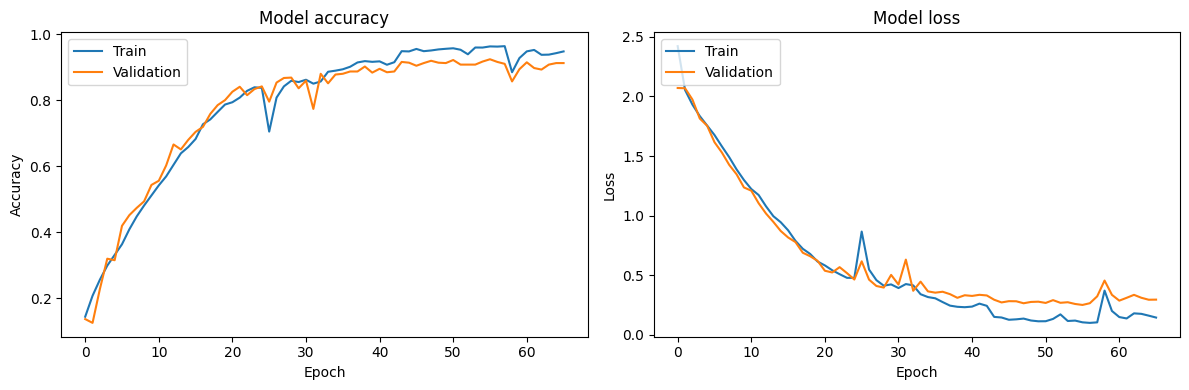

27/27 [==============================] - 4s 46ms/step


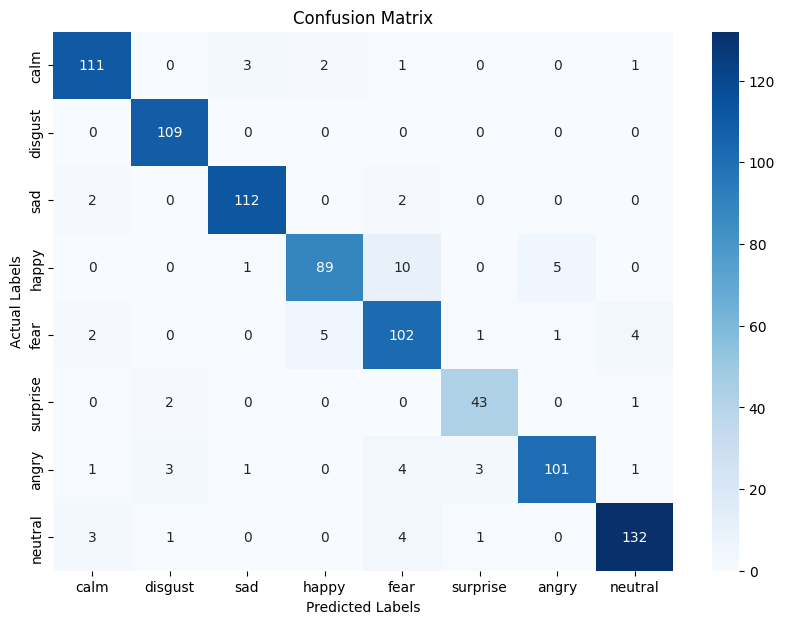

              precision    recall  f1-score   support

       angry       0.93      0.94      0.94       118
        calm       0.95      1.00      0.97       109
     disgust       0.96      0.97      0.96       116
        fear       0.93      0.85      0.89       105
       happy       0.83      0.89      0.86       115
     neutral       0.90      0.93      0.91        46
         sad       0.94      0.89      0.91       114
    surprise       0.95      0.94      0.94       141

    accuracy                           0.92       864
   macro avg       0.92      0.92      0.92       864
weighted avg       0.93      0.92      0.92       864

Accuracy: 92.48%
Training model: EfficientNetB6
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.4199 - accuracy: 0.1429
Epoch 1: val_accuracy improved from -inf to 0.15509, saving model to RAVDESS 100EfficientNetB6_best.h5
216/216 [==============================] - 77s 280ms/step - loss: 2.4199 - accuracy: 0.1429 - val_loss: 2.0672 - val_accuracy: 0.1551 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 2.1180 - accuracy: 0.1589
Epoch 2: val_accuracy did not improve from 0.15509
216/216 [==============================] - 56s 257ms/step - loss: 2.1180 - accuracy: 0.1589 - val_loss: 2.0630 - val_accuracy: 0.1447 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 2.0511 - accuracy: 0.1645
Epoch 3: val_accuracy improved from 0.15509 to 0.16319, saving model to RAVDESS 100EfficientNetB6_best.h5
216/216 [==============================] - 58s 267ms/step - loss: 2.0511 - accuracy: 0.1645 - val_loss: 2.0310 - val_accuracy: 0.1632 - lr: 0.0100
Epoch 4/100
216/216 

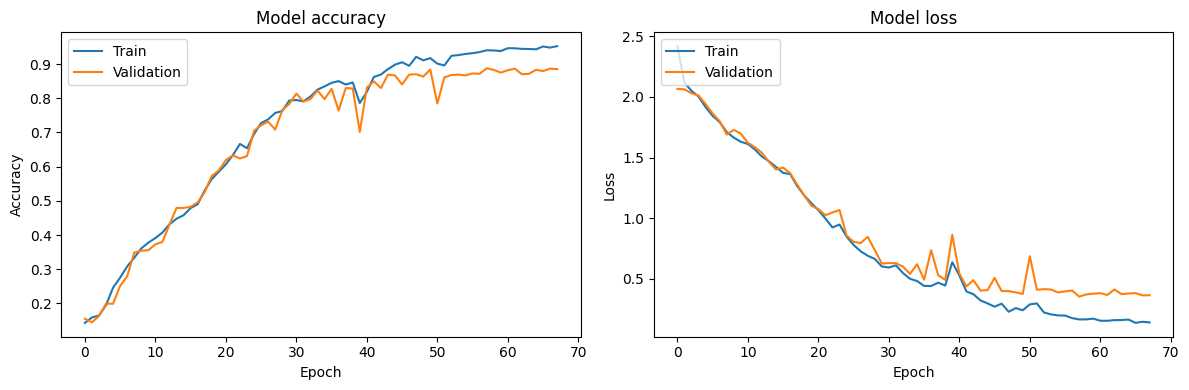

27/27 [==============================] - 4s 58ms/step


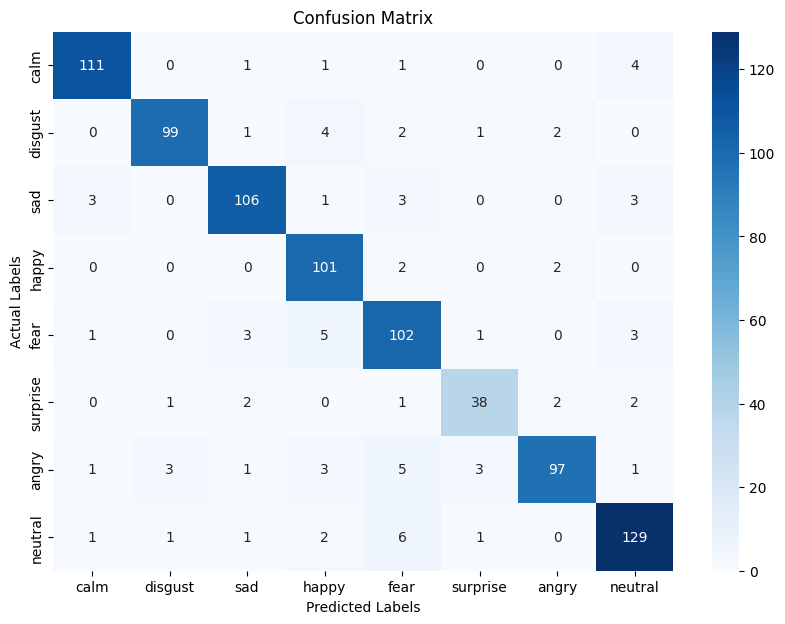

              precision    recall  f1-score   support

       angry       0.95      0.94      0.94       118
        calm       0.95      0.91      0.93       109
     disgust       0.92      0.91      0.92       116
        fear       0.86      0.96      0.91       105
       happy       0.84      0.89      0.86       115
     neutral       0.86      0.83      0.84        46
         sad       0.94      0.85      0.89       114
    surprise       0.91      0.91      0.91       141

    accuracy                           0.91       864
   macro avg       0.90      0.90      0.90       864
weighted avg       0.91      0.91      0.91       864

Accuracy: 90.62%
Training model: EfficientNetB7
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 40, 1, 1)]   0           []                   

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


216/216 [==============================] - ETA: 0s - loss: 2.4372 - accuracy: 0.1536
Epoch 1: val_accuracy improved from -inf to 0.13773, saving model to RAVDESS 100EfficientNetB7_best.h5
216/216 [==============================] - 100s 365ms/step - loss: 2.4372 - accuracy: 0.1536 - val_loss: 2.0732 - val_accuracy: 0.1377 - lr: 0.0100
Epoch 2/100
216/216 [==============================] - ETA: 0s - loss: 2.1020 - accuracy: 0.1604
Epoch 2: val_accuracy improved from 0.13773 to 0.14352, saving model to RAVDESS 100EfficientNetB7_best.h5
216/216 [==============================] - 75s 345ms/step - loss: 2.1020 - accuracy: 0.1604 - val_loss: 2.0538 - val_accuracy: 0.1435 - lr: 0.0100
Epoch 3/100
216/216 [==============================] - ETA: 0s - loss: 2.0582 - accuracy: 0.1651
Epoch 3: val_accuracy did not improve from 0.14352
216/216 [==============================] - 73s 336ms/step - loss: 2.0582 - accuracy: 0.1651 - val_loss: 2.0788 - val_accuracy: 0.1343 - lr: 0.0100
Epoch 4/100
216/216

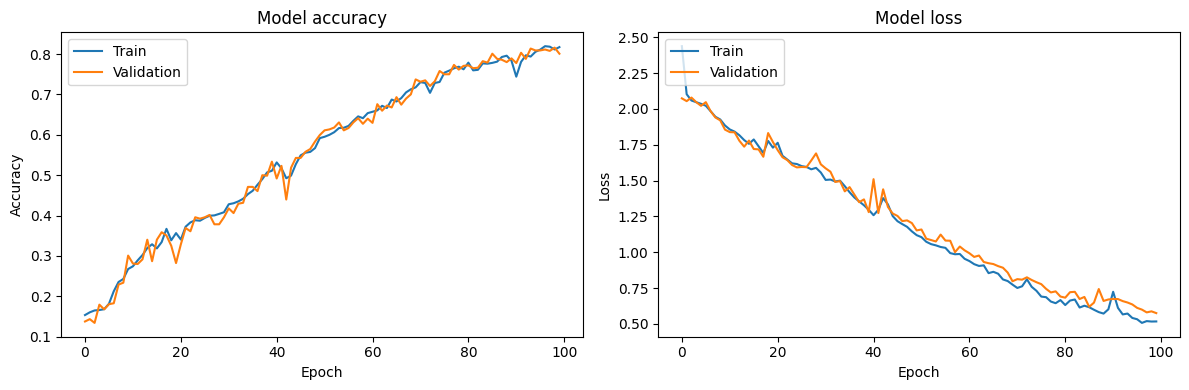

27/27 [==============================] - 8s 76ms/step


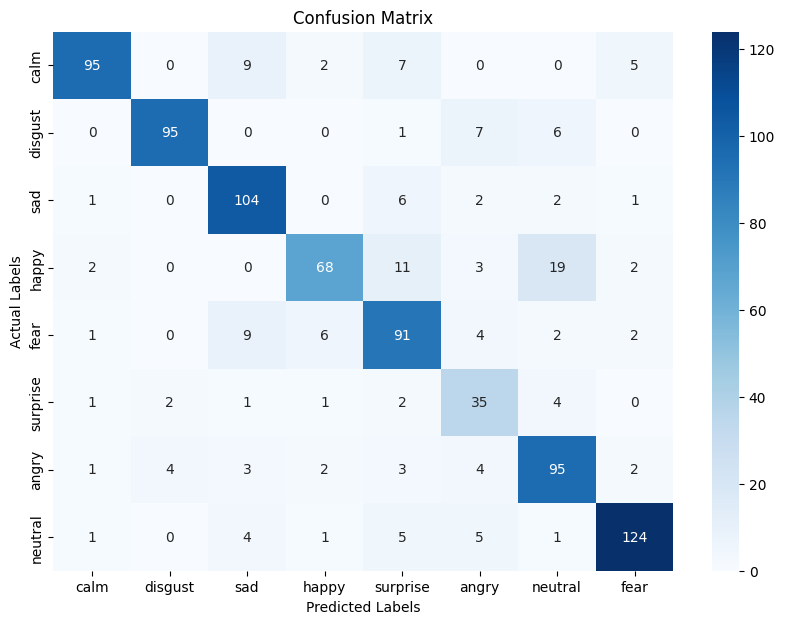

              precision    recall  f1-score   support

       angry       0.93      0.81      0.86       118
        calm       0.94      0.87      0.90       109
     disgust       0.80      0.90      0.85       116
        fear       0.85      0.65      0.74       105
       happy       0.72      0.79      0.76       115
     neutral       0.58      0.76      0.66        46
         sad       0.74      0.83      0.78       114
    surprise       0.91      0.88      0.90       141

    accuracy                           0.82       864
   macro avg       0.81      0.81      0.81       864
weighted avg       0.83      0.82      0.82       864

Accuracy: 81.83%


In [23]:
# model_types = [
#     'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 
#     'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7',
#     'EfficientNetV2B0', 'EfficientNetV2B1', 'EfficientNetV2B2', 'EfficientNetV2B3',
#     'EfficientNetV2S', 'EfficientNetV2M', 'EfficientNetV2L'
# ]

model_types = [
    'EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 
    'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7'
]

for model_type in model_types:
    print(f"Training model: {model_type}")
    model, history = create_resnet_model(model_type, 100, 'RAVDESS 100 ' + model_type)
    evaluate_model(model)
    plot_history(history)
    create_model_summary(model)